# Fake News Prediction with Machine Learning

#### Installs Word Cloud 

In [1]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


#### Installs Natural Language Toolkit

In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


#### Imports required libraries

In [3]:
import re
import nltk
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from nltk import tokenize
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import chi2


#### Imports required algorithm models

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold

#### Imports fake and real news dataframes

In [5]:
df_fake = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')

In [6]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
df_true.head() 

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


#### Adds a "class" coloumn for fake and real news dataframes for categorisation 

In [8]:
df_fake['class'] = 0
df_true['class'] = 1

#### Shows the number of dimensions in the array of both dataframes

In [9]:
df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

#### Merges fake and real news dataframes

In [10]:
df_merge = pd.concat([df_fake,df_true], axis = 0)

#### Drops unnecessary columns from the dataframe

In [11]:
df = df_merge.drop(['title', 'date'], axis = 1)
df.head()

,text,subject,class
0,Donald Trump just couldn t wish all Americans ...,News,0
1,House Intelligence Committee Chairman Devin Nu...,News,0
2,"On Friday, it was revealed that former Milwauk...",News,0
3,"On Christmas day, Donald Trump announced that ...",News,0
4,Pope Francis used his annual Christmas Day mes...,News,0


#### Checks the dataframe for any missing values

In [12]:
df.isnull().sum()

text       0
subject    0
class      0
dtype: int64

#### Shuffles the dataframe randomly

In [13]:
df = df.sample(frac = 1)

#### Determines the amount of data to be taken from the dataframe (500 records)

In [14]:
#df=df[0:1000]
print (df.shape)

(44898, 3)


In [15]:
df.head(10)

,text,subject,class
20737,MADRID (Reuters) - Spanish Prime Minister Mari...,worldnews,1
1950,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,1
10928,He threw the reputation of the FBI under the ...,politics,0
8830,"WARSAW, Poland (Reuters) - President Barack Ob...",politicsNews,1
7113,SANTIAGO (Reuters) - Countries involved in the...,politicsNews,1
15443,BERLIN (Reuters) - German police have launched...,worldnews,1
8082,After the death of Supreme Court Justice Anton...,News,0
13142,It s a federal offense to threaten a president...,politics,0
17404,This story should send chills down the spine o...,Government News,0
14741,ZURICH (Reuters) - Switzerland will stop seizi...,worldnews,1


#### Creates a function that converts the text to lowercase, removes extra spacing, special characters, url, links and punctuations


In [16]:
def word_drop(text):
    text = text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('<.*?>+','',text)
    text = re.sub('[%s]'%re.escape(string.punctuation),'',text)
    text = re.sub('\n','',text)
    text = re.sub('\w*\d\w*','',text)
    return text

In [17]:
df['text'] = df['text'].apply(word_drop)

In [18]:
df.head()

,text,subject,class
20737,madrid reuters spanish prime minister mari...,worldnews,1
1950,washington reuters president donald trump ...,politicsNews,1
10928,he threw the reputation of the fbi under the ...,politics,0
8830,warsaw poland reuters president barack ob...,politicsNews,1
7113,santiago reuters countries involved in the...,politicsNews,1


#### Defines dependent and independent variables as X and y from the dataframe

In [19]:
X = df.iloc[:,0].values
y = df.iloc[:,-1].values

#### Converts the headlines' and bodies' text into vectors

In [20]:
vectoriser = TfidfVectorizer(min_df=25, max_df=0.5, ngram_range=(1,2), stop_words='english',sublinear_tf=True, norm='l2', encoding='latin-1')
Xv = vectoriser.fit_transform(X).todense()

#### Removes 'stopwords' from the text

In [21]:
nltk.download('stopwords')
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoniecruz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Shows the subject distribution of the news

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


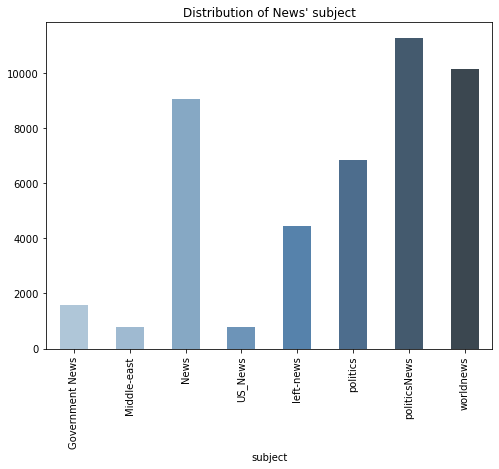

In [22]:
print(df.groupby(['subject'])['text'].count())
fig = plt.figure(figsize=(8,6))
tl = plt.title("Distribution of News' subject")
df.groupby(['subject'])['text'].count().plot(kind="bar", color = ['#afc6d8', '#9fbad1', '#86a8c4', '#6d94b8', '#5682ab', '#4d6d8d', '#445a6e', '#3b4750'])
plt.show()

#### Shows the distribution of fake and real news

class
0    23481
1    21417
Name: text, dtype: int64


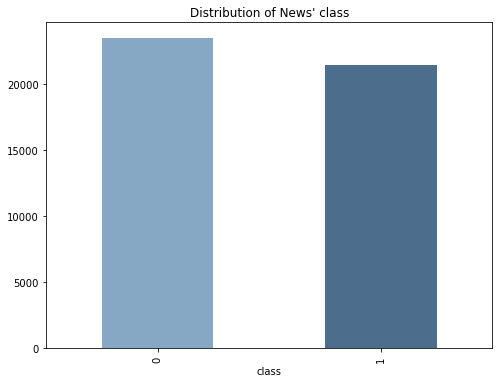

In [23]:
print(df.groupby(['class'])['text'].count())
fig = plt.figure(figsize=(8,6))
tl = plt.title("Distribution of News' class")
df.groupby(['class'])['text'].count().plot(kind='bar', color =['#86a8c4', '#4d6d8d'])
plt.show()

#### Tokenises the text to find the most frequent words used

In [24]:
token_space = tokenize.WhitespaceTokenizer()
def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", palette="Blues_d")
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')

#### Top 20 most frequent words in Fake News

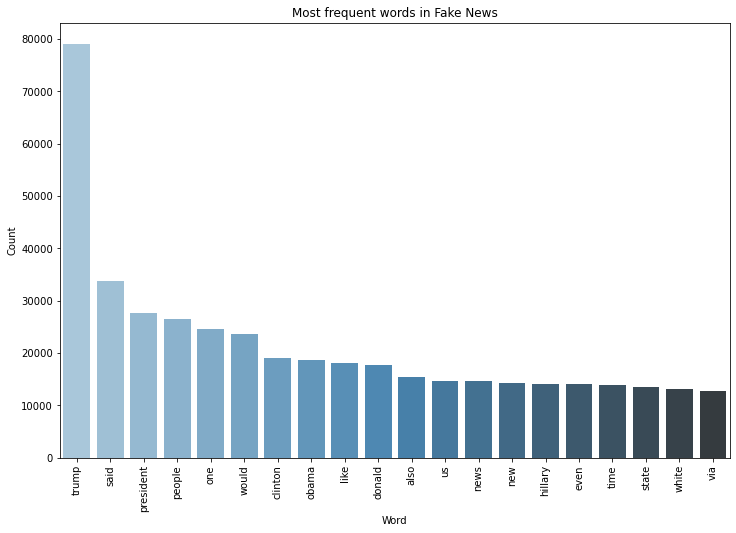

In [25]:
counter(df[df['class'] == 0], 'text', 20)
plt.title('Most frequent words in Fake News')
plt.show()

#### Most frequent words in Fake News (Visualised in WordCloud)

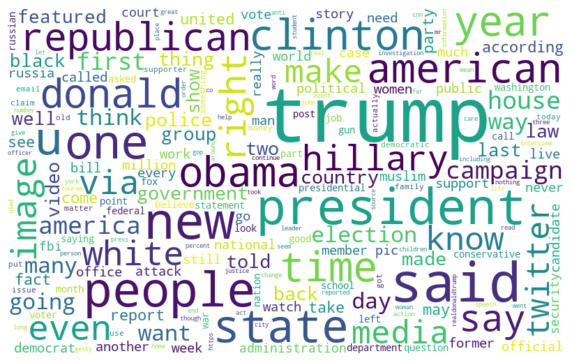

In [26]:
fake_data = df[df['class'] == 0]
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          background_color= 'white',
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Top 20 most frequent words in Real News

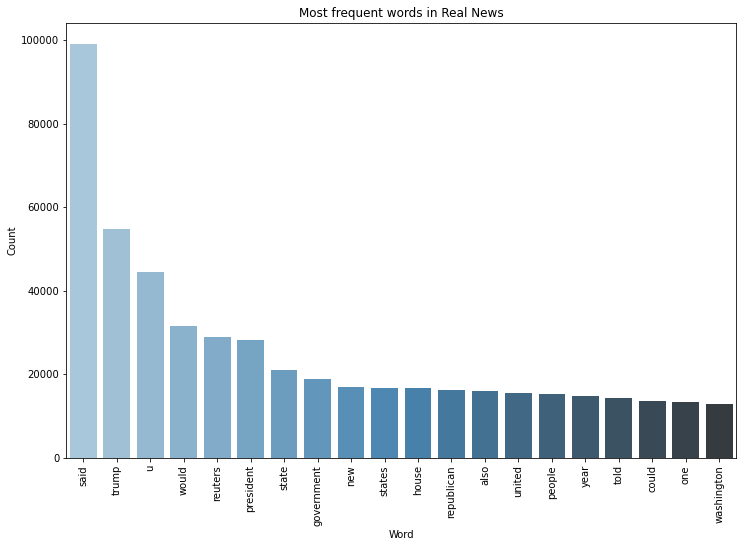

In [27]:
counter(df[df['class'] == 1], 'text', 20)
plt.title('Most frequent words in Real News')
plt.show()

#### Most frequent words in Real News (Visualised in WordCloud)

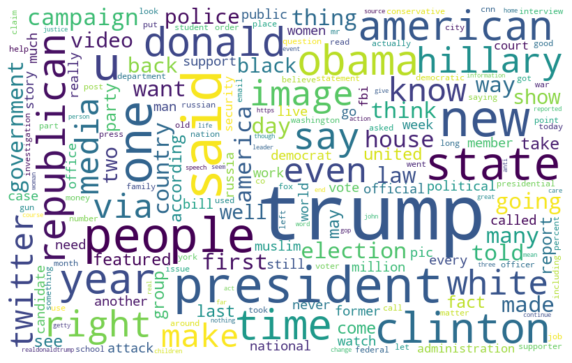

In [28]:
real_data = df[df['class'] == 1]
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          background_color= 'white',
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Splits the dataframe into training and testing sets (75:25)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(Xv, y, test_size=0.25, random_state=0)

## Machine Learning Algorithms

### 1) Logistic Regression

In [30]:
LR = LogisticRegression()
LR.fit(X_train, y_train)
pred_LR = LR.predict(X_test)

In [31]:
target_names = ['Fake','True']
print(classification_report(y_test, pred_LR, target_names=target_names))

              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      5911
        True       0.99      0.99      0.99      5314

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



Accuracy:  0.9920712694877506


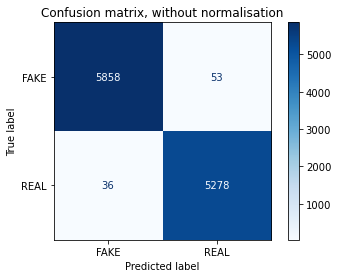

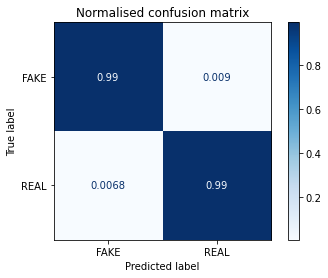

In [32]:
titles_options = [("Confusion matrix, without normalisation", None),("Normalised confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(LR, X_test, y_test,
                                 display_labels=['FAKE','REAL'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
       
print ("Accuracy: ", LR.score(X_test, y_test))

plt.show()

### 2) Decision Tree Classification

In [33]:
DT = DecisionTreeClassifier(criterion='entropy')
DT.fit(X_train, y_train)
pred_DT = DT.predict(X_test)

In [34]:
print(classification_report(y_test, pred_DT, target_names=target_names))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5911
        True       1.00      0.99      1.00      5314

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



Accuracy:  0.995456570155902


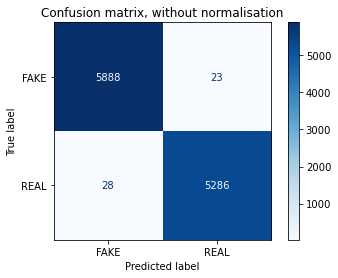

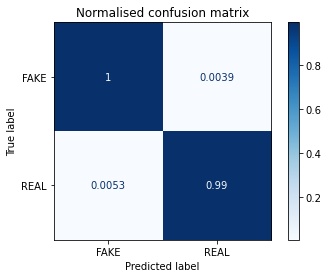

In [35]:
titles_options = [("Confusion matrix, without normalisation", None),("Normalised confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(DT, X_test, y_test,
                                 display_labels=['FAKE','REAL'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
       
print ("Accuracy: ", DT.score(X_test, y_test))

plt.show()

### 3) Gradient Boosting Classifier

In [36]:
GB = GradientBoostingClassifier(random_state = 0)
GB.fit(X_train, y_train)
pred_GB = GB.predict(X_test)

In [37]:
print(classification_report(y_test, pred_GB, target_names=target_names))

              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00      5911
        True       0.99      1.00      0.99      5314

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



Accuracy:  0.9951002227171493


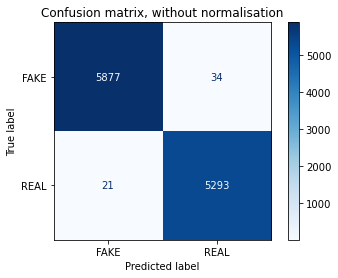

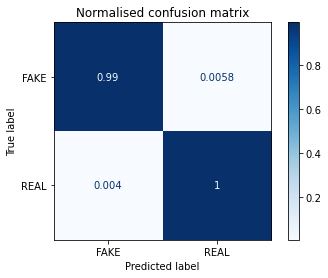

In [38]:
titles_options = [("Confusion matrix, without normalisation", None),("Normalised confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(GB, X_test, y_test,
                                 display_labels=['FAKE','REAL'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
       
print ("Accuracy: ", GB.score(X_test, y_test))

plt.show()

### 4) Random Forest Classifier

In [39]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(X_train, y_train)
pred_RF = RF.predict(X_test)

In [40]:
print(classification_report(y_test, pred_RF, target_names=target_names))

              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00      5911
        True       0.99      1.00      1.00      5314

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



Accuracy:  0.9955456570155902


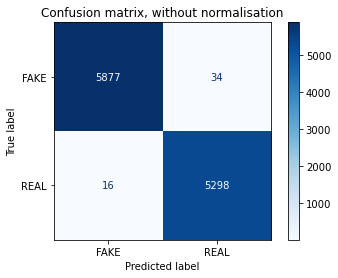

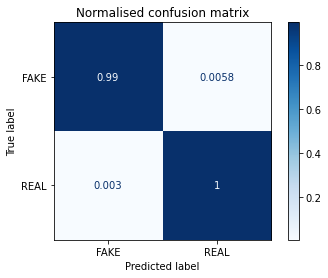

In [41]:
titles_options = [("Confusion matrix, without normalisation", None),("Normalised confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(RF, X_test, y_test,
                                 display_labels=['FAKE','REAL'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
       
print ("Accuracy: ", RF.score(X_test, y_test))

plt.show()

### 5) K-Nearest Neighbour Classifier

In [42]:
KN = KNeighborsClassifier(n_neighbors = 10)
KN.fit(X_train, y_train)
pred_KN = KN.predict(X_test)

In [43]:
print(classification_report(y_test, pred_KN, target_names=target_names))

              precision    recall  f1-score   support

        Fake       0.53      1.00      0.69      5911
        True       1.00      0.01      0.02      5314

    accuracy                           0.53     11225
   macro avg       0.76      0.51      0.36     11225
weighted avg       0.75      0.53      0.38     11225



Accuracy:  0.5323830734966593


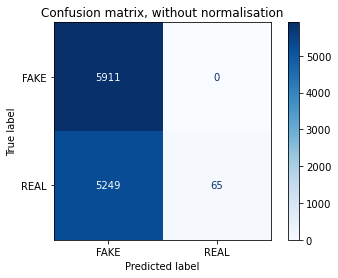

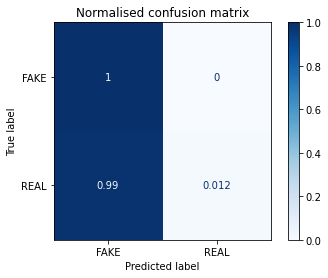

In [44]:
titles_options = [("Confusion matrix, without normalisation", None),("Normalised confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(KN, X_test, y_test,
                                 display_labels=['FAKE','REAL'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
       
print ("Accuracy: ", KN.score(X_test, y_test))

plt.show()

### 6) Support Vector Classifier

In [ ]:
SV = SVC()
SV.fit(X_train, y_train)
pred_SV = SV.predict(X_test)

In [ ]:
print(classification_report(y_test, pred_SV, target_names=target_names))

In [ ]:
titles_options = [("Confusion matrix, without normalisation", None),("Normalised confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(SV, X_test, y_test,
                                 display_labels=['FAKE','REAL'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
       
print ("Accuracy: ", SV.score(X_test, y_test))

plt.show()

### 7) Gaussian Naive Bayes

In [ ]:
GN = GaussianNB()
GN.fit(X_train, y_train)
pred_GN = GN.predict(X_test)

In [ ]:
print(classification_report(y_test, pred_GN, target_names=target_names))

In [ ]:
titles_options = [("Confusion matrix, without normalisation", None),("Normalised confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(GN, X_test, y_test,
                                 display_labels=['FAKE','REAL'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
       
print ("Accuracy: ", GN.score(X_test, y_test))

plt.show()

## Accuracy Scores Comparison

### Train/Test Split

In [ ]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('GNB', GaussianNB()))

In [ ]:
names = []
scores = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

### Accuracy of Classifiers Graph (Train/Test Split)

In [ ]:
axis = sns.barplot(x = 'Name', y = 'Score', data = tr_split, palette="Blues_d")
axis.set(xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center")
plt.title('Train/Test Split Accuracy Scores')
plt.show()

### K-Fold Cross-Validation

In [ ]:
names = []
scores = []
for name, model in models:
    
    kfold = KFold(n_splits=10, random_state=10, shuffle=True) 
    score = cross_val_score(model, Xv, y, cv=kfold, scoring='accuracy').mean()
    
    names.append(name)
    scores.append(score)
kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

### Accuracy of Classifiers Graph (K-Fold Cross-Validation)

In [ ]:
axis = sns.barplot(x = 'Name', y = 'Score', data = kf_cross_val, palette="Blues_d")
axis.set(xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
plt.title('K-Fold Cross-Validation Accuracy Scores')
plt.show()

## Fake News Prediction from Manual Entry

#### Creates a function that converts the text to lowercase, removes extra spacing, special characters, url, links and punctuations and returns an output that states whether the manually input entry was fake or real news based from the used algorithms

In [ ]:
def output_label(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "True News"
    else:
        return "Error!"
    
def manual_testing(news):
    testing_news = {'text':[news]}
    mt_df_test = pd.DataFrame(testing_news)
    mt_df_test['text'] = mt_df_test['text'].apply(word_drop)
    mt_X_test = mt_df_test['text']
    mt_xv_test = vectoriser.transform(mt_X_test).todense()
    
    names = []
    prediction = []
    for name, model in models:
        m_pred = model.predict(mt_xv_test)
        prediction.append(output_label(m_pred))
        names.append(name)
        manual_test = pd.DataFrame({'Classifier': names, 'Prediction': prediction})
    return print("\n",manual_test)

#### A function where to manually input the news for prediction

In [ ]:
news = input("Insert News Text Here: \n")
manual_testing(news)